In [ ]:
import keras
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split

In [ ]:
#Problem 4(a)

(X_train, y_train), (X_test, y_test) = datasets.cifar10.load_data()
print(X_train.shape)
print(X_test.shape)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

X_train = X_train/255.0
X_test = X_test/255.0



(50000, 32, 32, 3)
(10000, 32, 32, 3)


In [ ]:
print(y_train.shape)
print(y_train[0])

(50000, 1)
[6]


In [ ]:
Y_train = keras.utils.np_utils.to_categorical(y_train)
Y_test = keras.utils.np_utils.to_categorical(y_test)
num_class = Y_test.shape[1]
print(num_class)
print(Y_train.shape)
print(Y_train[0])


10
(50000, 10)
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


In [ ]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

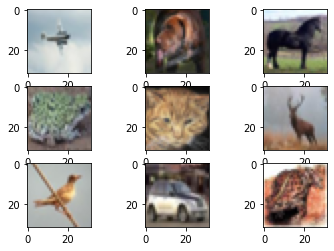

In [ ]:
#create a grid of 3x3 images
for i in range(0,9):
  plt.subplot(330 + 1 + i)
  img = X_train[50 + i]
  plt.imshow(img)
plt.show()

In [ ]:
#Problem 4(b)

def convolution_block(filters, kernel_size, input_shape=None):
    block = Sequential()
    if input_shape:
        block.add(Conv2D(filters, kernel_size, input_shape=input_shape, activation='relu', padding='same'))
    else:
        block.add(Conv2D(filters, kernel_size, activation='relu', padding='same'))
    block.add(MaxPooling2D(pool_size=(2, 2)))
    block.add(BatchNormalization())
    return block


In [ ]:
model = Sequential()

model.add(convolution_block(32, (3, 3), input_shape=(32, 32, 3)))
model.add(convolution_block(64, (3, 3)))
model.add(convolution_block(128, (3, 3)))
model.add(convolution_block(256, (3, 3)))


model.add(Flatten())


model.add(Dense(10, activation='softmax'))


In [ ]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
model.fit(X_train, Y_train, batch_size=128, epochs=10, validation_data=(X_val, Y_val)) #epochs=10 original


Epoch 1/10
313/313 [==============================] - 142s 451ms/step - loss: 1.3013 - accuracy: 0.5469 - val_loss: 2.5546 - val_accuracy: 0.2128
Epoch 2/10
313/313 [==============================] - 136s 433ms/step - loss: 0.8316 - accuracy: 0.7107 - val_loss: 1.1211 - val_accuracy: 0.6065
Epoch 3/10
313/313 [==============================] - 135s 430ms/step - loss: 0.6161 - accuracy: 0.7871 - val_loss: 0.9011 - val_accuracy: 0.6991
Epoch 4/10
313/313 [==============================] - 136s 435ms/step - loss: 0.4556 - accuracy: 0.8449 - val_loss: 0.9441 - val_accuracy: 0.7034
Epoch 5/10
313/313 [==============================] - 135s 432ms/step - loss: 0.3271 - accuracy: 0.8898 - val_loss: 0.9871 - val_accuracy: 0.7011
Epoch 6/10
313/313 [==============================] - 139s 444ms/step - loss: 0.2112 - accuracy: 0.9320 - val_loss: 0.9485 - val_accuracy: 0.7166
Epoch 7/10
313/313 [==============================] - 137s 437ms/step - loss: 0.1302 - accuracy: 0.9607 - val_loss: 0.9605 -

In [ ]:
model.evaluate(X_test,Y_test)

313/313 [==============================] - 9s 29ms/step - loss: 1.3585 - accuracy: 0.7129


[1.358510971069336, 0.7128999829292297]

In [ ]:
#Problem 4(c)
#Replacing CNN with Inception Blocks

from tensorflow.keras.layers import Conv2D, MaxPooling2D, Concatenate, AveragePooling2D

def inception_block(x, filters):
    """
    Implementation of the Inception block.

    Arguments:
    x -- input tensor
    filters -- list of integers, filters for each branch

    Returns:
    output tensor
    """
    
    branch_1x1 = Conv2D(filters=filters[0], kernel_size=(1, 1), padding='same', activation='relu')(x)
    
    branch_3x3 = Conv2D(filters=filters[1], kernel_size=(1, 1), padding='same', activation='relu')(x)
    branch_3x3 = Conv2D(filters=filters[2], kernel_size=(3, 3), padding='same', activation='relu')(branch_3x3)
    
    branch_5x5 = Conv2D(filters=filters[3], kernel_size=(1, 1), padding='same', activation='relu')(x)
    branch_5x5 = Conv2D(filters=filters[4], kernel_size=(5, 5), padding='same', activation='relu')(branch_5x5)
    
    branch_pool = MaxPooling2D(pool_size=(3, 3), strides=(1, 1), padding='same')(x)
    branch_pool = Conv2D(filters=filters[5], kernel_size=(1, 1), padding='same', activation='relu')(branch_pool)
    
    output = Concatenate(axis=-1)([branch_1x1, branch_3x3, branch_5x5, branch_pool])
    
    return output
  


input_shape = X_train[0].shape
num_class = Y_test.shape[1]


input_tensor = keras.Input(shape=input_shape)

x = Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu')(input_tensor)
x = inception_block(x, filters=[16, 16, 16, 16, 16, 16])
#x = inception_block(x, filters=[32, 32, 32, 32, 32, 32])
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Flatten()(x)
x = Dense(units=256, activation='relu')(x)
# x = Dropout(rate=0.5)(x) #Gives error
output_tensor = Dense(units=num_class, activation='softmax')(x)

# Define the model
model = keras.Model(inputs=input_tensor, outputs=output_tensor)


# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, Y_train, batch_size=128, epochs=10, validation_data=(X_test, Y_test)) #epochs=10 original

# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, Y_test)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

Epoch 1/10
313/313 [==============================] - 312s 992ms/step - loss: 1.5489 - accuracy: 0.4512 - val_loss: 1.2756 - val_accuracy: 0.5405
Epoch 2/10
313/313 [==============================] - 306s 977ms/step - loss: 1.1470 - accuracy: 0.5967 - val_loss: 1.1130 - val_accuracy: 0.6036
Epoch 3/10
313/313 [==============================] - 308s 984ms/step - loss: 0.9797 - accuracy: 0.6532 - val_loss: 1.1073 - val_accuracy: 0.6142
Epoch 4/10
313/313 [==============================] - 311s 995ms/step - loss: 0.8646 - accuracy: 0.6990 - val_loss: 0.9815 - val_accuracy: 0.6616
Epoch 5/10
313/313 [==============================] - 307s 980ms/step - loss: 0.7748 - accuracy: 0.7290 - val_loss: 1.0233 - val_accuracy: 0.6449
Epoch 6/10
313/313 [==============================] - 307s 981ms/step - loss: 0.6866 - accuracy: 0.7588 - val_loss: 0.9670 - val_accuracy: 0.6709
Epoch 7/10
313/313 [==============================] - 308s 984ms/step - loss: 0.6060 - accuracy: 0.7874 - val_loss: 1.0310 -

In [ ]:
#Problem 4(d)
# Replacing Inception Blocks with Residual Blocks

from keras.layers import Input, Add, Conv2D, BatchNormalization, Activation

def residual_block(input_tensor, filters, stride=1):
    """
    Residual block implementation in Keras.
    """
    x = Conv2D(filters=filters, kernel_size=(3, 3), strides=stride, padding='same')(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters=filters, kernel_size=(3, 3), strides=1, padding='same')(x)
    x = BatchNormalization()(x)

    if stride != 1:
        input_tensor = Conv2D(filters=filters, kernel_size=(1, 1), strides=stride, padding='same')(input_tensor)
        input_tensor = BatchNormalization()(input_tensor)

    x = Add()([x, input_tensor])
    x = Activation('relu')(x)

    return x


# Define the input shape
input_shape = X_train[0].shape

# Define the number of filters for each residual block
num_filters = 32

# Define the input tensor
inputs = Input(shape=input_shape)

# Apply the first convolutional layer
x = Conv2D(filters=num_filters, kernel_size=(3, 3), padding='same')(inputs)
x = BatchNormalization()(x)
x = Activation('relu')(x)

# Apply 3 residual blocks
x = residual_block(x, filters=num_filters, stride=1)
x = residual_block(x, filters=num_filters, stride=1)
# x = residual_block(x, filters=num_filters, stride=1)

# Apply the final layers
x = Flatten()(x)
x = Dense(units=512, activation='relu')(x)
outputs = Dense(units=10, activation='softmax')(x)

# Define the model
model = keras.Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, Y_train, batch_size=128, epochs=10, validation_data=(X_test, Y_test)) #epochs=10 original

# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, Y_test)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

Epoch 1/10
313/313 [==============================] - 627s 2s/step - loss: 5.1503 - accuracy: 0.3871 - val_loss: 2.9296 - val_accuracy: 0.1716
Epoch 2/10
313/313 [==============================] - 642s 2s/step - loss: 1.2543 - accuracy: 0.5528 - val_loss: 1.6202 - val_accuracy: 0.4571
Epoch 3/10
313/313 [==============================] - 635s 2s/step - loss: 1.0518 - accuracy: 0.6266 - val_loss: 1.2074 - val_accuracy: 0.5784
Epoch 4/10
313/313 [==============================] - 631s 2s/step - loss: 0.9041 - accuracy: 0.6819 - val_loss: 2.1502 - val_accuracy: 0.4685
Epoch 5/10
313/313 [==============================] - 625s 2s/step - loss: 0.7859 - accuracy: 0.7236 - val_loss: 1.4872 - val_accuracy: 0.5391
Epoch 6/10
313/313 [==============================] - 641s 2s/step - loss: 0.6822 - accuracy: 0.7593 - val_loss: 1.3554 - val_accuracy: 0.5675
Epoch 7/10
313/313 [==============================] - 627s 2s/step - loss: 0.5999 - accuracy: 0.7886 - val_loss: 1.1356 - val_accuracy: 0.6356